# Image Stitching

In [3]:
# Import libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

In [15]:
# Common variables

test_img = "train_images/Set1/1.jpg"
test_img2 = "train_images/Set2/2.jpg"

#### Corner Detection

In [7]:
# Compute likelihood of each pixel being a corner
def detect_corner(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  corner_scores = cv2.cornerHarris(gray_img, 2, 3, 0.04)
  return corner_scores

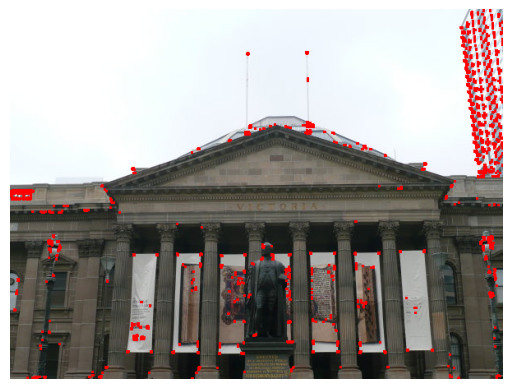

In [10]:
# Display image with potential corners marked

# Read an image
img = cv2.imread(test_img)

# Mark image with red dots at each potential corner
corner_scores = detect_corner(img)
corner_scores = cv2.dilate(corner_scores, None)
img[corner_scores > 0.01 * corner_scores.max()] = [0, 0, 255]

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### True Corner Detection with Adaptive Non-Maximal Suppression (ANMS)

In [12]:
# Calculate euclidean distance between points
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Calculate best point to represent a corner
def ANMS(cmap, num_best):
    corner_scores_flat = cmap.flatten()
    idx_1d = corner_scores_flat.argsort()[-num_best * 4:]
    x_idx, y_idx = np.unravel_index(idx_1d, corner_scores.shape)

    local_maxima_idx = []
    for x,y in zip(x_idx,y_idx):
        local_maxima_idx.append([x,y])

    r_i = [sys.maxsize] * len(local_maxima_idx)

    for i in range(len(local_maxima_idx)):
        for j in range(len(local_maxima_idx)):
            if i == j:
                continue
            point1 = local_maxima_idx[i]
            point2 = local_maxima_idx[j]

            dist = sys.maxsize

            if corner_scores[point1[0]][point1[1]] > corner_scores[point2[0]][point2[1]]:
                dist = euclidean_distance(point1, point2)
            if dist < r_i[i]:
                r_i[i] = dist

    for i in range(len(r_i)):
        if r_i[i] == sys.maxsize:
            r_i[i] = 0
    
    to_return = []
    ind = np.argpartition(r_i, -num_best)[-num_best:]
    for index in ind:
        to_return.append(local_maxima_idx[index])

    for lst in to_return:
        tmp = lst[0]
        lst[0] = lst[1]
        lst[1] = tmp

    return to_return

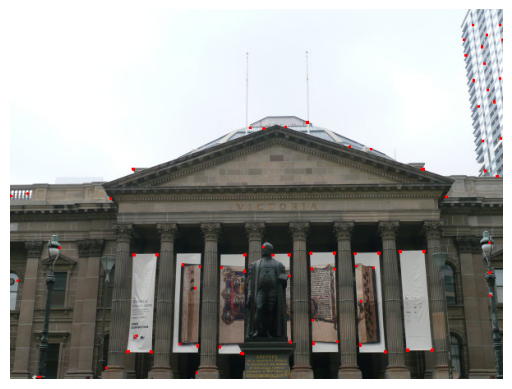

In [14]:
# Display image with corners marked

# Read image
img = cv2.imread(test_img)

# AMNS to calculate true corner points
corners = ANMS(detect_corner(img), 150)

# Binary image with marked corners
zeros = np.zeros_like(img)
for corner in corners:
    zeros[corner[1], corner[0]] = 1
dilated_arr = cv2.dilate(zeros, None)

# Mark corner with red dot
for i in range(zeros.shape[0]):
    for j in range(zeros.shape[1]):
        if np.any(dilated_arr[i][j]):
            img[i][j] = [0,0,255]

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()